# Download the Data

In [ ]:
# Changes are made to accomodate google colab as cannot use Amazon SageMaker :(
    # nvm, doesn't work

In [ ]:
!pip3 install tqdm
!pip3 install pillow --upgrade
!pip3 install boto3
!pip3 install sagemaker

In [ ]:
%matplotlib inline

import os
import io
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


# Visualize Data

In [ ]:
trimaps_dir = 'data/annotations/trimaps/'

maps = [x for x in os.listdir(trimaps_dir) if x[-3:] == 'png']
print(len(maps))

14780


In [ ]:
image_dir = 'data/images/'

images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

7390


In [ ]:
images[0]

'Egyptian_Mau_196.jpg'

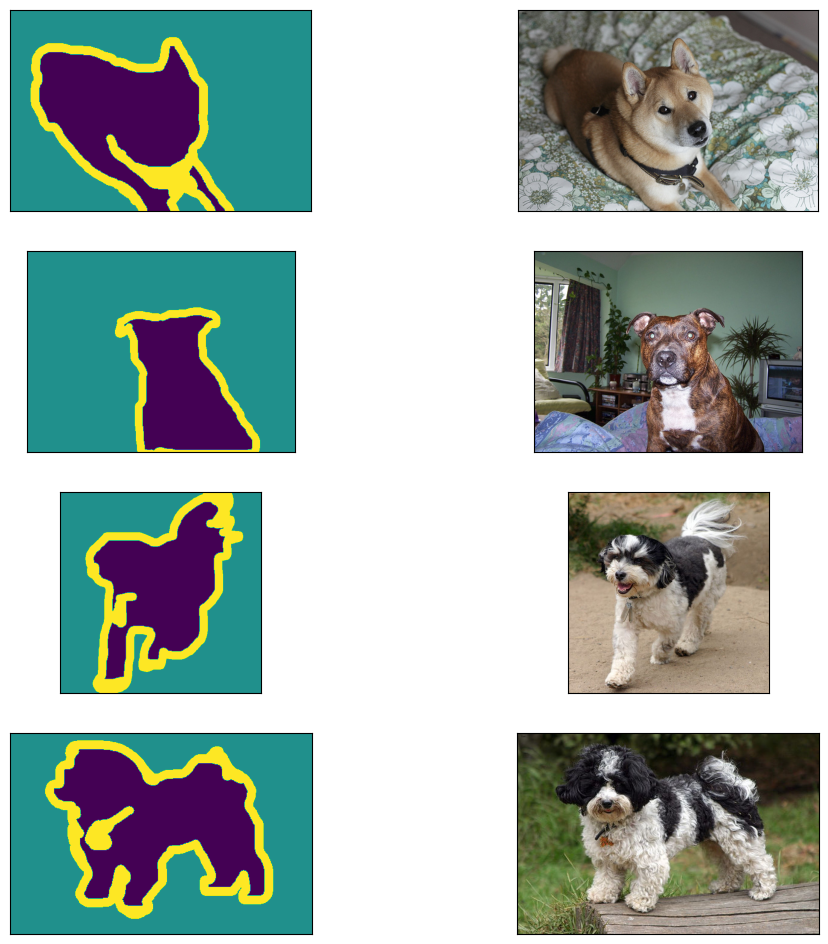

In [ ]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_name = images[index]
    map_name = images[index].split('.')[0] + '.png'

    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(trimaps_dir, map_name)))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(image_dir, image_name)))
plt.show()

In [ ]:
img = Image.open(os.path.join(trimaps_dir, maps[0]))
print(np.unique(img))

[1 2 3]


# SageMaker Setup

In [35]:
print(boto3.Session().region_name)

role = sagemaker.get_execution_role()
bucket_name = 'petsdata'
# training_image = get_image_uri(boto3.Session().region_name,
#                                'semantic-segmentation',
#                                repo_version = 'latest'
#                                )

training_image = get_image_uri('us-west-1',
                               'semantic-segmentation',
                               repo_version = 'latest'
                               )

print(training_image)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


None
632365934929.dkr.ecr.us-west-1.amazonaws.com/semantic-segmentation:1


In [36]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [37]:
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file

for image in tqdm(images):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'

    image_file_path = os.path.join('data/images/', image)
    image_target_path = os.path.join(target_set, image)

    map_file_path = os.path.join(trimaps_dir, get_map_file(image))
    map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))

    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)

100%|██████████| 7390/7390 [00:12<00:00, 590.28it/s] 


In [38]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [39]:
print(len(train_annots), len(train_images))

5533 5533


# Uploading Data to S3

In [ ]:
sess = sagemaker.Session()

print('Starting Upload')
s3_train_path = sess.upload_data(path = 'train',
                                 bucket = bucket_name,
                                 key_prefix = 'train'
                                 )
print('Training Images Uploaded')

s3_train_annotation_path = sess.upload_data(path = 'train_annotation',
                                            bucket = bucket_name,
                                            key_prefix = 'train_annotation'
                                            )
print('Training Annotations Uploaded')

s3_validation_path = sess.upload_data(path = 'validation',
                                            bucket = bucket_name,
                                            key_prefix = 'validation'
                                            )
print('Validation Images Uploaded')

s3_validation_annotation_path = sess.upload_data(path = 'validation_annotation',
                                            bucket = bucket_name,
                                            key_prefix = 'validation_annotation'
                                            )
print('Validation Annotation Uploaded')

In [ ]:
s3_validation_annotation_path

# SageMaker Estimator

In [ ]:
model = sagemaker.estimator.Estimator(
    training_image,
    role = role,
    training_instance_count = 1,
    train_instance_type = 'ml.p3.2xlarge',
    train_volume_size = 100,
    train_max_run = 36000,
    input_mode = 'File',
    output_path = 's3://petsdata/output',
    sagemaker_session = sess
)

# Hyperparameters

In [ ]:
model.set_hyperparameters(
    backbone = 'resnet-50',
    algorithm = 'fcn',
    use_pretrained_model = True,
    crop_size = 240,
    num_classes = 4, # 4 because the sagemaker counts from 0, 1, 2, 3 and data has only 1, 2, 3
    epochs = 10,
    learning_Rate = 0.0001,
    optimizer = 'rmsprop',
    lr_scheduler = 'poly',
    mini_batch_size = 16,
    validation_mini_batch_size = 16,
    num_training_samples = len(train_images)
)

# Data Channels

In [ ]:
train_data = sagemaker.session.s3_input(s3_train_path,
                                        distribution = 'FullyReplicated',
                                        content_type = 'image/jpeg',
                                        s3_data_type = 'S3Prefix'
                                        )

validation_data = sagemaker.session.s3_input(s3_validation_path,
                                        distribution = 'FullyReplicated',
                                        content_type = 'image/jpeg',
                                        s3_data_type = 'S3Prefix'
                                        )

train_annotation_data = sagemaker.session.s3_input(s3_train_annotation_path,
                                        distribution = 'FullyReplicated',
                                        content_type = 'image/png',
                                        s3_data_type = 'S3Prefix'
                                        )

validation_annotation_data = sagemaker.session.s3_input(s3_tvalidation_annotation_path,
                                        distribution = 'FullyReplicated',
                                        content_type = 'image/png',
                                        s3_data_type = 'S3Prefix'
                                        )

In [ ]:
data_channel = {
    'train' : train_data,
    'validation' : validation_data,
    'train_annotation' : train_annotation_data,
    'validation_annotation' : validation_annotation_data
}

In [ ]:
data_channel

# Model Training

In [ ]:
model.fit(inputs = data_channel, logs = True)

# Deploy Model

In [ ]:
deployed_model = model.deploy(initial_instance_count = 1,
                              instance_type = 'ml.m4.xlarge'
                              )
print("\n Model Deployed")

# Predictions

In [ ]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

In [ ]:
deployed_model.content_type = 'image/jpeg'
deployed_model.accept = 'image/png'

In [ ]:
index = 2

image_path = os.path.join(image_dir, images[index])
# image_path = 'dog_cat.jfif'

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b)

In [ ]:
mask = np.array(Image.open(io.BytesIO(results)))

In [ ]:
plt.imshow(plt.imread(image_path));

In [ ]:
plt.imshow(mask);

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [ ]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)

In [ ]:
# Finished Finally !!!